# Global Vegetation Trends: A multi-decade, planet-covering and analysis ready product 

In this tutorial, you will learn how to access the Global Vegetation Trends product generated by [OpenGeoHub](https://opengeohub.org/), which consists in a bi-monthly vegetation index time series ([MOD13Q1.006 EVI](https://lpdaac.usgs.gov/products/mod13q1v006/)) without clouds, gapfilled and analysis ready. The clouds and cloud shadows were removed using as reference the [pixel reliability band](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13Q1) (``pixel values > 1``). The remained artifacts were screened by a [moving window approach](https://eumap.readthedocs.io/en/latest/_autosummary/eumap.gapfiller.ImageGapfill.html) able to identify outliers based on local median and standard deviation values, and the gaps were filled using a time-first ([TMWM](https://eumap.readthedocs.io/en/latest/_autosummary/eumap.gapfiller.TMWM.html)) space-later ([InPainting](https://eumap.readthedocs.io/en/latest/_autosummary/eumap.gapfiller.InPainting.html)) approach. The gapfilled VI time series were deseasonalized by the [STL algorithm](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.STL.html#statsmodels.tsa.seasonal.STL), producing a VI trend time series which were analyzed a [OLS regression](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.STL.html#statsmodels.tsa.seasonal.STL) to derive several long-term temporal metrics on a pixel basis (``alpha, beta,  P>|t|, rsqr``).

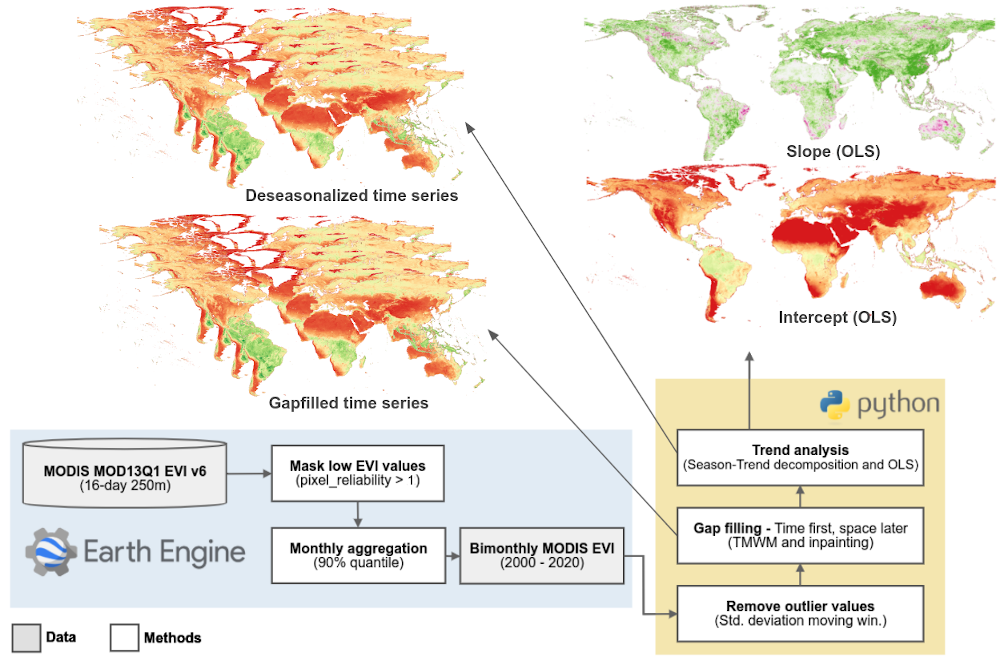

This entire dataset is publicly available through [Cloud Optimized GeoTIFF (COG)](https://www.cogeo.org/), allowing easy and direct access by different GIS softwares (QGIS) and programming languages (Python and R). The COG format takes advantage of the very flexible and time-proven (Geo)TIFF image format to enable fast reading of large raster files, especially in a cloud hosted environments. The specification does several things to achieve this:
 - it uses efficient compression (deflate), in terms of balancing compression ratio and decompression speed
 - blocks are efficiently organized into tiles (e.g. 1024x1024 pixels)
 - overviews are built for several zoom levels to speed up resampling into lower resolutions

First, let's import the necessary modules and functions used by the tutorial:

In [1]:
from functions.access import *
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

The follow helper functions are provided to retrieve the URL addresses for the COG files

In [2]:
mod13q1_evi_urls = get_mod13q1_evi_urls()
mod13q1_evi_flags_urls = get_mod13q1_evi_flags_urls()
mod13q1_evi_trend_urls = get_mod13q1_evi_trend_urls()
mod13q1_evi_ols_urls = get_mod13q1_evi_ols_urls()

idx = 0
print(f"EVI COG URLS ({len(mod13q1_evi_urls)} files)")
print(f' - Gapfilled: {mod13q1_evi_urls[idx]}')
print(f' - Gapfilled flag: {mod13q1_evi_flags_urls[idx]}')
print(f' - Trend: {mod13q1_evi_trend_urls[idx]}')

EVI COG URLS (126 files)
 - Gapfilled: https://s3.eu-central-1.wasabisys.com/openlandmap/veg/veg_evi.mod13q1_tmwm.inpaint_p90_250m_0..0cm_2000.01.01..2000.02.28_v0.2.tif
 - Gapfilled flag: https://s3.eu-central-1.wasabisys.com/openlandmap/veg/veg_evi.mod13q1_tmwm.inpaint_f_250m_0..0cm_2000.01.01..2000.02.28_v0.2.tif
 - Trend: https://s3.eu-central-1.wasabisys.com/openlandmap/veg/veg_evi.mod13q1_stl.trend_p90_250m_0..0cm_2000.01.01..2000.02.28_v0.2.tif


...and the files produced by the OLS regressions.

In [3]:
print(f"OLG regression URLS ({len(mod13q1_evi_ols_urls)} files)")
for url in mod13q1_evi_ols_urls:
    print(f' - {url}')

OLG regression URLS (13 files)
 - https://s3.eu-central-1.wasabisys.com/openlandmap/veg/veg_evi.mod13q1_stl.trend.logit.ols.alpha_m_250m_0..0cm_2000..2020_v0.2.tif
 - https://s3.eu-central-1.wasabisys.com/openlandmap/veg/veg_evi.mod13q1_stl.trend.logit.ols.alpha_l.025_250m_0..0cm_2000..2020_v0.2.tif
 - https://s3.eu-central-1.wasabisys.com/openlandmap/veg/veg_evi.mod13q1_stl.trend.logit.ols.alpha_pv_250m_0..0cm_2000..2020_v0.2.tif
 - https://s3.eu-central-1.wasabisys.com/openlandmap/veg/veg_evi.mod13q1_stl.trend.logit.ols.alpha_sd_250m_0..0cm_2000..2020_v0.2.tif
 - https://s3.eu-central-1.wasabisys.com/openlandmap/veg/veg_evi.mod13q1_stl.trend.logit.ols.alpha_tv_250m_0..0cm_2000..2020_v0.2.tif
 - https://s3.eu-central-1.wasabisys.com/openlandmap/veg/veg_evi.mod13q1_stl.trend.logit.ols.alpha_u.975_250m_0..0cm_2000..2020_v0.2.tif
 - https://s3.eu-central-1.wasabisys.com/openlandmap/veg/veg_evi.mod13q1_stl.trend.logit.ols.beta_m_250m_0..0cm_2000..2020_v0.2.tif
 - https://s3.eu-central-1.w

## Overview Access

It's possible to use the [rasterio](https://rasterio.readthedocs.io/en/latest/) library to access the metadata of these files without read all the data to the memory:

In [4]:
idx = 0
url = mod13q1_evi_urls[idx]
src = rasterio.open(url)

print(f'File {url}\n')
for (key, val) in src.profile.items():
    print(f'-{key}: {val}')

File https://s3.eu-central-1.wasabisys.com/openlandmap/veg/veg_evi.mod13q1_tmwm.inpaint_p90_250m_0..0cm_2000.01.01..2000.02.28_v0.2.tif

-driver: GTiff
-dtype: int16
-nodata: -32768.0
-width: 160300
-height: 65200
-count: 1
-crs: EPSG:4326
-transform: | 0.00, 0.00,-180.00|
| 0.00,-0.00, 84.28|
| 0.00, 0.00, 1.00|
-blockxsize: 1024
-blockysize: 1024
-tiled: True
-compress: deflate
-interleave: band


Multiplying the ``width`` by the ``height`` it's possible to understand that it's a BIG image:

In [5]:
n_pixels = src.profile['width'] * src.profile['height']
print(f'Total number of pixels: {n_pixels}')

Total number of pixels: 10451560000


However you can use the COG structure to calculate the shape of a low resolution overview, reading a small portion of the data in a quickly thumbnail format:

In [6]:
idx = 10
overview, src = read_overview(mod13q1_evi_urls[idx], oviews_pos=5, verbose=True)
print(f'\nOverview dimensions: {overview.shape}')

Reading https://s3.eu-central-1.wasabisys.com/openlandmap/veg/veg_evi.mod13q1_tmwm.inpaint_p90_250m_0..0cm_2001.09.01..2001.10.31_v0.2.tif
-Available overviews: [2, 4, 8, 16, 32, 64, 128, 256]

Overview dimensions: (1018, 2504)


Let's plot the resulting thumbnail:

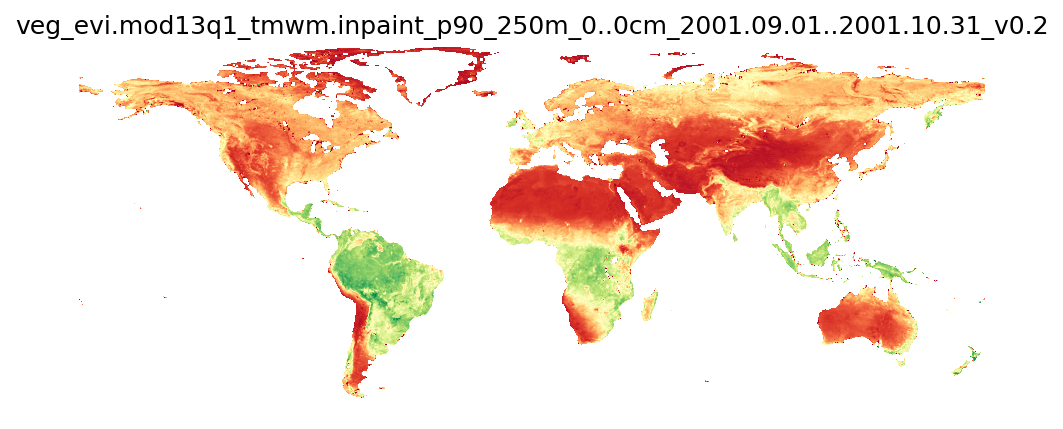

In [7]:
from eumap import plotter
plotter.plot_rasters(overview, figsize=8, cmaps='RdYlGn', nodata=src.nodata, vmin=0, vmax=8000, titles=[Path(mod13q1_evi_urls[idx]).stem])

You can iterate over the URL list plotting multiple dates:

Reading https://s3.eu-central-1.wasabisys.com/openlandmap/veg/veg_evi.mod13q1_tmwm.inpaint_p90_250m_0..0cm_2000.01.01..2000.02.28_v0.2.tif
-Available overviews: [2, 4, 8, 16, 32, 64, 128, 256]
Reading https://s3.eu-central-1.wasabisys.com/openlandmap/veg/veg_evi.mod13q1_tmwm.inpaint_p90_250m_0..0cm_2000.03.01..2000.04.30_v0.2.tif
-Available overviews: [2, 4, 8, 16, 32, 64, 128, 256]
Reading https://s3.eu-central-1.wasabisys.com/openlandmap/veg/veg_evi.mod13q1_tmwm.inpaint_p90_250m_0..0cm_2000.05.01..2000.06.30_v0.2.tif
-Available overviews: [2, 4, 8, 16, 32, 64, 128, 256]
Reading https://s3.eu-central-1.wasabisys.com/openlandmap/veg/veg_evi.mod13q1_tmwm.inpaint_p90_250m_0..0cm_2000.07.01..2000.08.31_v0.2.tif
-Available overviews: [2, 4, 8, 16, 32, 64, 128, 256]
Reading https://s3.eu-central-1.wasabisys.com/openlandmap/veg/veg_evi.mod13q1_tmwm.inpaint_p90_250m_0..0cm_2000.09.01..2000.10.31_v0.2.tif
-Available overviews: [2, 4, 8, 16, 32, 64, 128, 256]
Reading https://s3.eu-central-1.was

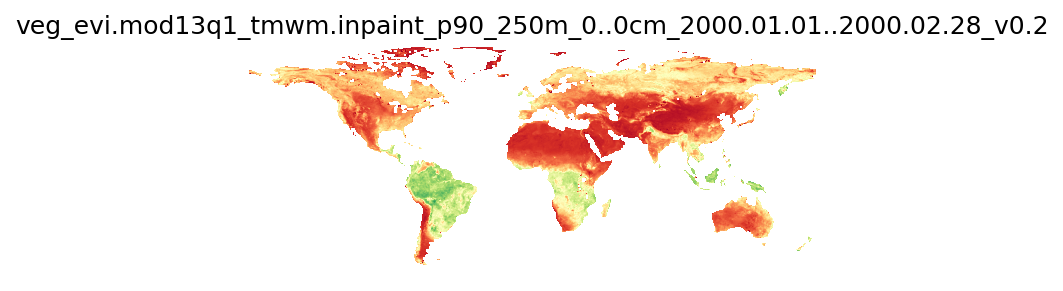

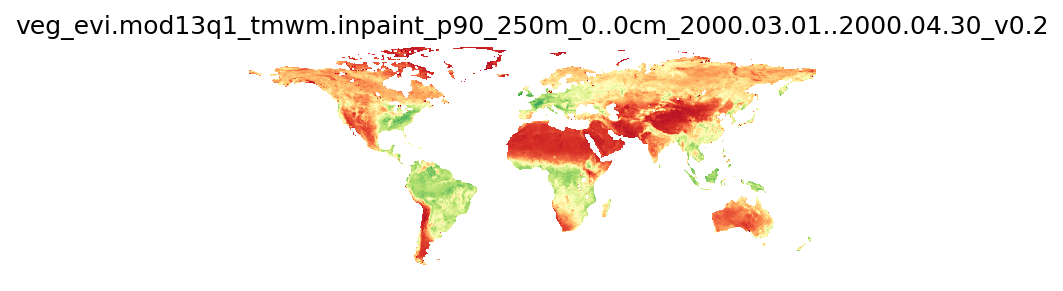

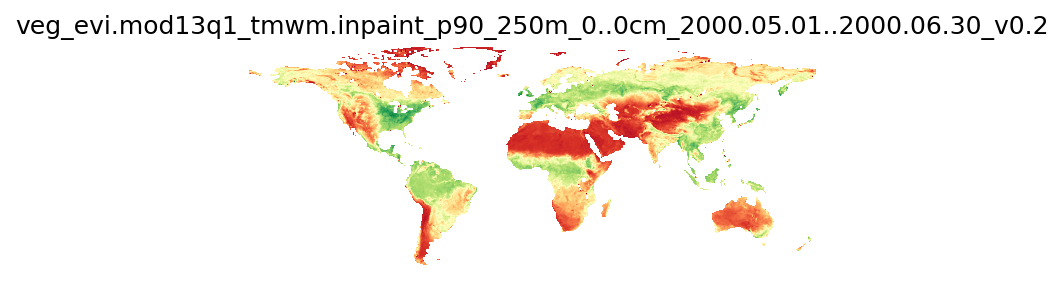

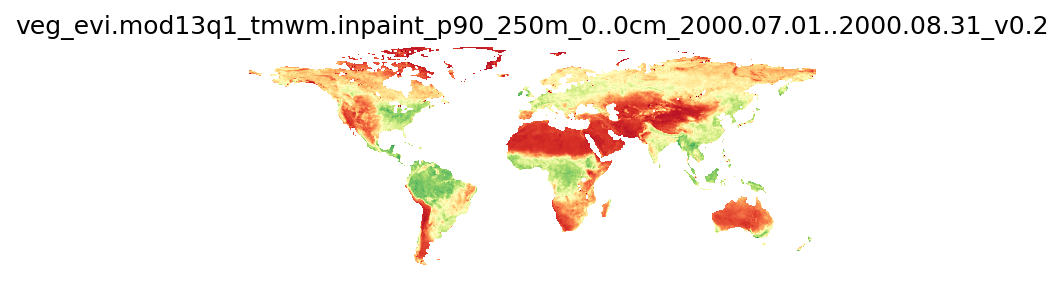

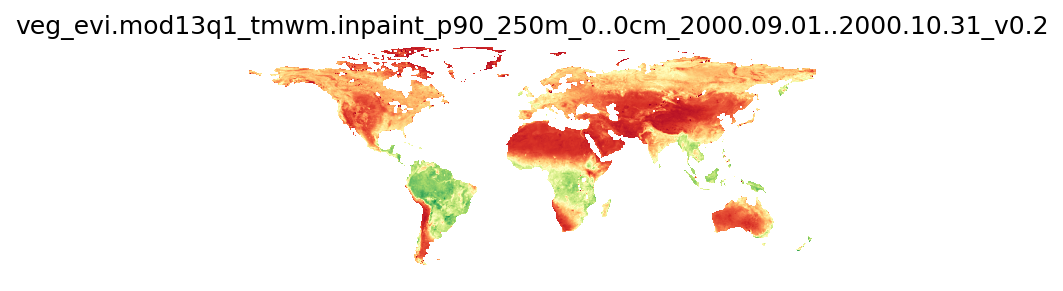

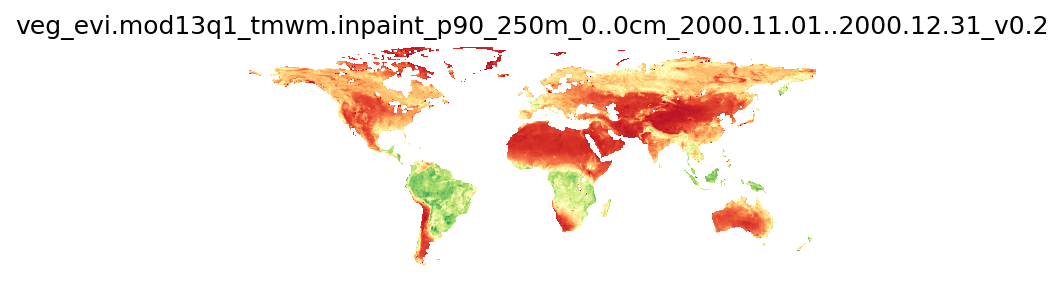

In [8]:
for idx in range(0,6):
    overview, src = read_overview(mod13q1_evi_urls[idx], oviews_pos=5, verbose=True)
    plotter.plot_rasters(overview, figsize=5, cmaps='RdYlGn', nodata=src.nodata, vmin=0, vmax=8000, titles=[Path(mod13q1_evi_urls[idx]).stem])

## Reading and Writing

To access the dataset in a full resolution, it's recommended subset the COG file by a geographic region. 

To help in the definition of this region, let's make an interactive map with [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/), defining a `DrawControl` and add it to the map controls.

In [10]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl, LayersControl

m = Map(center=(51.98, 5.65), zoom = 2, basemap= basemaps.OpenStreetMap.Mapnik)

draw_control = DrawControl()
draw_control.rectangle = {
    "shapeOptions": {
        "color": "#ff0000",
        "fillOpacity": 0,
        "opacity": 1
    }
}

m.add_control(draw_control)
m.add_control(LayersControl())

m

Map(center=[51.98, 5.65], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

You can now select the feature from `DrawControl.data` and get its bounds.

In [11]:
from shapely.geometry import shape
from rasterio.windows import Window, from_bounds

geometry = shape(draw_control.data[-1]['geometry'])
bounds = geometry.bounds
window = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], src.transform)
print("\nBounds: ", bounds[0], bounds[1], bounds[2], bounds[3])
print("Raster window:", window)


Bounds:  -47.790527 -14.686062 -43.813477 -11.927989
Raster window: Window(col_off=58870.93147850038, row_off=42837.26338011086, width=1770.8927234384319, height=1228.1091277233063)


With the defined window you can quickly read the COG file using the [eumap.raster.read_raster](https://eumap.readthedocs.io/en/latest/_autosummary/eumap.raster.read_rasters.html#eumap.raster.read_rasters) function:

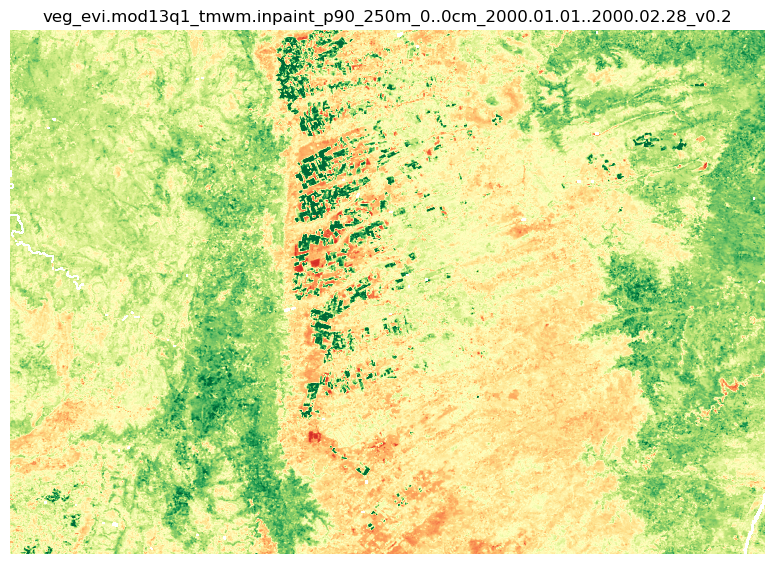

In [12]:
from eumap.raster import read_rasters, save_rasters

idx = 0
cog_url = mod13q1_evi_urls[idx]

data, _ = read_rasters(raster_files=[cog_url], spatial_win=window)
plotter.plot_rasters(data[:,:,0].astype('Float32'), cmaps='RdYlGn', dpi=100, nodata=src.nodata, vmin=0, vmax=8000, titles=[Path(cog_url).stem])

Let's compare with the last image of the time series:

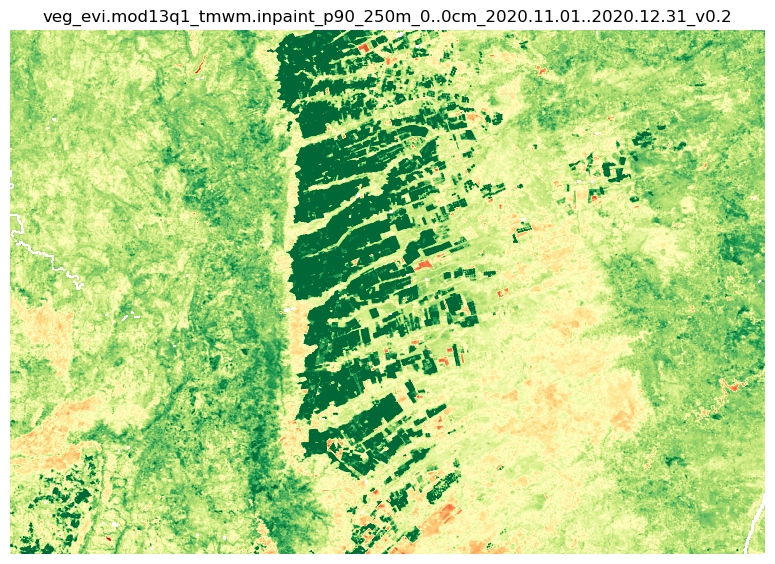

In [13]:
idx = len(mod13q1_evi_urls) - 1
cog_url = mod13q1_evi_urls[idx]

data, _ = read_rasters(raster_files=[cog_url], spatial_win=window)
plotter.plot_rasters(data[:,:,0].astype('Float32'), cmaps='RdYlGn', dpi=100, nodata=src.nodata, vmin=0, vmax=8000, titles=[Path(cog_url).stem])

You can also visualize the trend result based in the OLS regression:

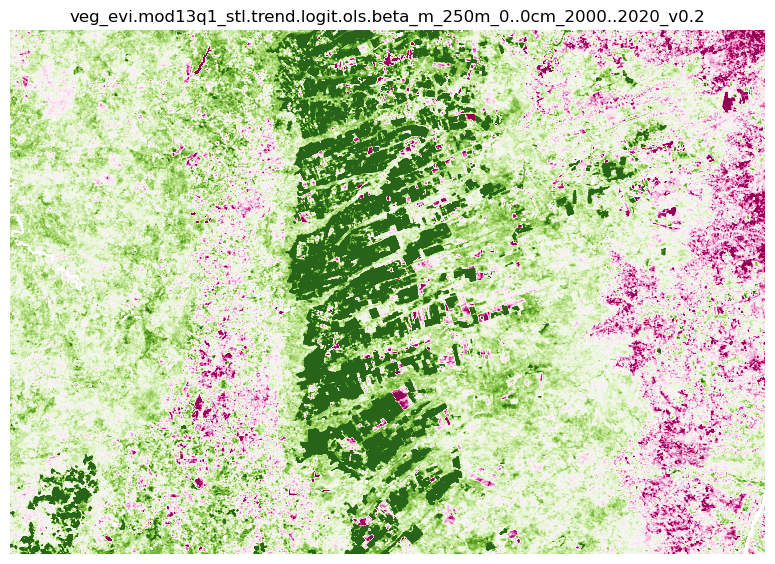

In [14]:
cog_url = mod13q1_evi_ols_urls[6]

data, _ = read_rasters(raster_files=[cog_url], spatial_win=window, dtype='float32')
plotter.plot_rasters(data[:,:,0], cmaps='PiYG', dpi=100, nodata=src.nodata, vmin=-0.5, vmax=0.5, titles=[Path(cog_url).stem])

Using [eumap.raster.save_rasters](https://eumap.readthedocs.io/en/latest/_autosummary/eumap.raster.save_rasters.html) you can save the clipped data by passing the COG as the reference file along with the window definition:

In [15]:
raster_dir = Path(os.getcwd())

file_name = f'{Path(mod13q1_evi_urls[idx]).stem}_clip_matopiba.tif'
file_path = raster_dir.joinpath(file_name)

print(f"Saving file in {file_path}")
r = save_rasters(cog_url, [file_path], data, spatial_win=window)

Saving file in /home/opengeohub/leandro/Code/global-layers/input_layers/MOD13Q1/veg_evi.mod13q1_tmwm.inpaint_p90_250m_0..0cm_2020.11.01..2020.12.31_v0.2_clip_matopiba.tif


## Time Series Access

Similarly, you can use the efficient structure of COG files to read a time series at a single point from the dateset. 

Let's make an interactive map again, this time to select a location by drawing a point marker

In [16]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl, LayersControl

m = Map(center=(51.98, 5.65), zoom = 2, basemap= basemaps.OpenStreetMap.Mapnik)

draw_control = DrawControl()
draw_control.point = {
    "shapeOptions": {
        "fillColor": "#ff0000",
        "color": "#ffffff",
        "fillOpacity": 0.6,
        "opacity": 1
    }
}

m.add_control(draw_control)
m.add_control(LayersControl())

m

Map(center=[51.98, 5.65], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

...and again select the geometry from the `DrawControl`.

In [27]:
from shapely.geometry import shape
geometry = shape(draw_control.data[-1]['geometry'])
lon, lat = geometry.x, geometry.y
print(lon, lat)

-45.808182 -13.944886


You can now use the point coordinates to sample the COG file with `rasterio`.

In [28]:
idx = 0
cog_url = mod13q1_evi_urls[idx]

with rasterio.open(cog_url) as ds:
    pixel_val = next(ds.sample([(lon, lat)]))
    print(f'{cog_url}')
    print(f' - Pixel value: {pixel_val}')

https://s3.eu-central-1.wasabisys.com/openlandmap/veg/veg_evi.mod13q1_tmwm.inpaint_p90_250m_0..0cm_2000.01.01..2000.02.28_v0.2.tif
 - Pixel value: [4200]


...and now you can run the sampling in parallel for multiple COG files, and then construct a [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) from the results.

In [29]:
evi_ts = read_ts(lon, lat, mod13q1_evi_urls)
evi_ts

raster_name  start_date  \
0    veg_evi.mod13q1_tmwm.inpaint_p90_250m_0..0cm_2...  2000-01-01   
1    veg_evi.mod13q1_tmwm.inpaint_p90_250m_0..0cm_2...  2000-03-01   
2    veg_evi.mod13q1_tmwm.inpaint_p90_250m_0..0cm_2...  2000-05-01   
3    veg_evi.mod13q1_tmwm.inpaint_p90_250m_0..0cm_2...  2000-07-01   
4    veg_evi.mod13q1_tmwm.inpaint_p90_250m_0..0cm_2...  2000-09-01   
..                                                 ...         ...   
121  veg_evi.mod13q1_tmwm.inpaint_p90_250m_0..0cm_2...  2020-03-01   
122  veg_evi.mod13q1_tmwm.inpaint_p90_250m_0..0cm_2...  2020-05-01   
123  veg_evi.mod13q1_tmwm.inpaint_p90_250m_0..0cm_2...  2020-07-01   
124  veg_evi.mod13q1_tmwm.inpaint_p90_250m_0..0cm_2...  2020-09-01   
125  veg_evi.mod13q1_tmwm.inpaint_p90_250m_0..0cm_2...  2020-11-01   

       end_date        lon        lat   value  
0    2000-02-28 -45.808182 -13.944886  4200.0  
1    2000-04-30 -45.808182 -13.944886  4200.0  
2    2000-06-30 -45.808182 -13.944886  3060.0  
3    2000-08-31 -45.808182 -13.944886  2940.0  
4    2000-10-31 -45.808182 -13.944886  3180.0  
..          ...        ...        ...     ...  
121  2020-04-30 -45.808182 -13.944886  5632.0  
122  2020-06-30 -45.808182 -13.944886  3436.0  
123  2020-08-31 -45.808182 -13.944886  1685.0  
124  2020-10-31 -45.808182 -13.944886  9040.0  
125  2020-12-31 -45.808182 -13.944886  9816.0  

[126 rows x 6 columns]

It's possible to save the result in a CSV file:

In [30]:
evi_ts.to_csv(raster_dir.joinpath('time_series_overlay.csv'))

You can also plot the trend and the OLS results:

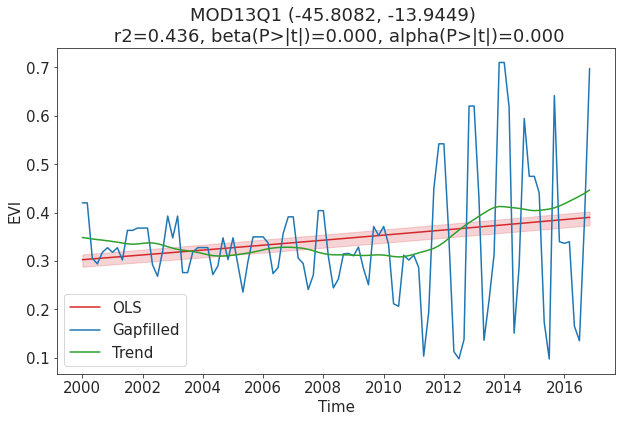

In [31]:
read_and_plot_ts(lat, lon, 2000, 2016)